In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090b_hw1.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 1: Clustering & Hierarchical Bayesian Models



**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas & Natesh Pillai


<hr style="height:2pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

## Notebook Contents
<a id="contents"></a>
- [**Part 0: K-means Clustering of Animal Traits**](#part0)
- **Bayesian Logistic Regression**
- [**Part 1: Varying-Intercept Model (Simulated Response Variable)**](#part1)
- [**Part 2: Varying-Intercept Model (Real Data)**](#part2)
- [**Part 3: Varying-Coefficients Model**](#part3)
- [**Part 4: Prediction & Model Selection**](#part4)

In [3]:
# Imports for Part 0
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
# You can decide what to import from the preprocessing module
from sklearn.metrics import pairwise_distances, silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

In [4]:
# measure notebook runtime
time_start = time.time()

<a id="part0"></a>

### <div class='exercise'>Part 0: K-means Clustering of Animal Traits</div> 
As a warm-up, we'll perform K-means clustering on a dataset of animal characteristics before moving on to our main Bayesian analysis.

[Return to contents](#contents)

<!-- BEGIN QUESTION -->
<div class='exercise'><b>Q0.1 - Data Preprocessing</b></div>

The file `zoo.csv` contains information about 100 different animals.

Load the data into a Pandas DataFrame and inspect the features. You will need to decide which columns it makes sense to include as input to the K-means clustering algorithm and what preprocessing you deem necessary. Store the processed features in a matrix `X`.

**Note:** You must justify your preprocessing decisions based on the nature of the features and your clustering objectives. This also applies to *negative* decisions (e.g., choices to *not* perform a generally standard type of preprocessing). 

In [5]:
zoo_df = pd.read_csv("data/zoo.csv")
display(zoo_df.head())

# drop the 'animal_name' column
animal_names = zoo_df["animal_name"]
X_raw = zoo_df.drop(columns=["animal_name"])

# OneHotEncoder the data
ohe = OneHotEncoder(sparse_output=False) 
X_encoded = ohe.fit_transform(X_raw)
col_names = ohe.get_feature_names_out(X_raw.columns)
X = pd.DataFrame(X_encoded, columns=col_names)


X.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


,hair_0,hair_1,feathers_0,feathers_1,eggs_0,eggs_1,milk_0,milk_1,airborne_0,airborne_1,...,domestic_1,catsize_0,catsize_1,class_type_1,class_type_2,class_type_3,class_type_4,class_type_5,class_type_6,class_type_7
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Answer
- The only column we decided to drop was the `animal_name` column because we were not entirely convinced of dropping any of the other columns.
- Even though one of the columns is `class_type`, we were curious to see how that would impact the clustering algorithm.
- We used `OneHotEncoder` because the majority of the data was either binary or categorical.
- We didn't drop the first column in the newly generated columns from `OneHotEncoder` because we know it's not entirely necessary for the clustering algorithm to work, just unnecssary.
- There was no need to apply the `StandardScaler()` object (which we mistakenly did at the beginning).

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q0.2 - PCA Visualization</b></div>
Before we begin clustering, we should attempt to visualize the data.

Create a 2D scatter plot of the data projected onto the first two principle components. Be sure to also report the variance explained by these components.

Based on your visualization, discuss whether you see evidence of natural clusters in the data.

**Hint:** There is a PCA projection plot in the penguin example at the end of the lab 1 notebook.

PC1 explained variance: 34.96%
PC2 explained variance: 19.60%


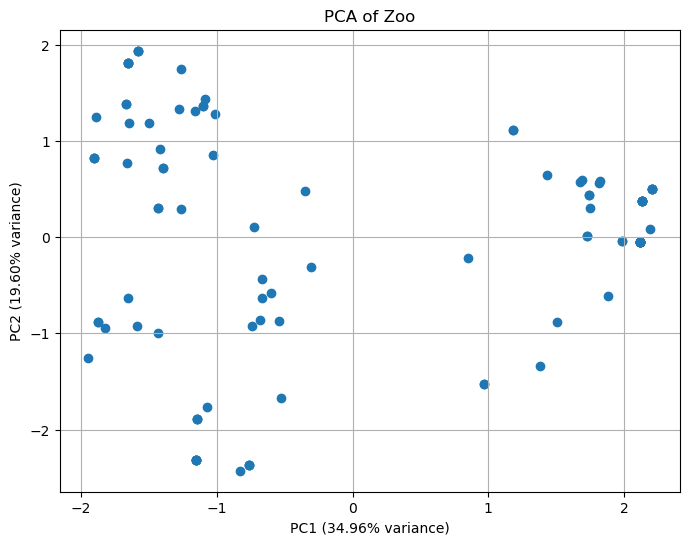

In [6]:
# pca
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
exp_var = pca.explained_variance_ratio_
print(f"PC1 explained variance: {exp_var[0]*100:.2f}%")
print(f"PC2 explained variance: {exp_var[1]*100:.2f}%")

# plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel(f"PC1 ({exp_var[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({exp_var[1]*100:.2f}% variance)")
plt.title("PCA of Zoo")
plt.grid(True)
plt.show()


# Answer

The graph shows evidence of clusters. We can see a cluster on the right, and 4-ish clusters on the lefthand side in a sort of diamond shape. We're not sure where exactly some of those border points (in between multiple clusters) would go, but I guess we will find out!

<!-- BEGIN QUESTION -->
<div class='exercise'><b>Q0.3 - Determining Optimal $k$</b></div>
Implement and visualize two different methods for determining the optimal number of clusters:

1. Plot the inertia vs $k$ for $k \in \{2,3,\dots,20\}$
2. Plot the average silhouette score vs $k$ for the same range

Choose and justify your optimal k based on these metrics. Discuss any differences between what the metrics suggest and whether one seems more reliable for this dataset.

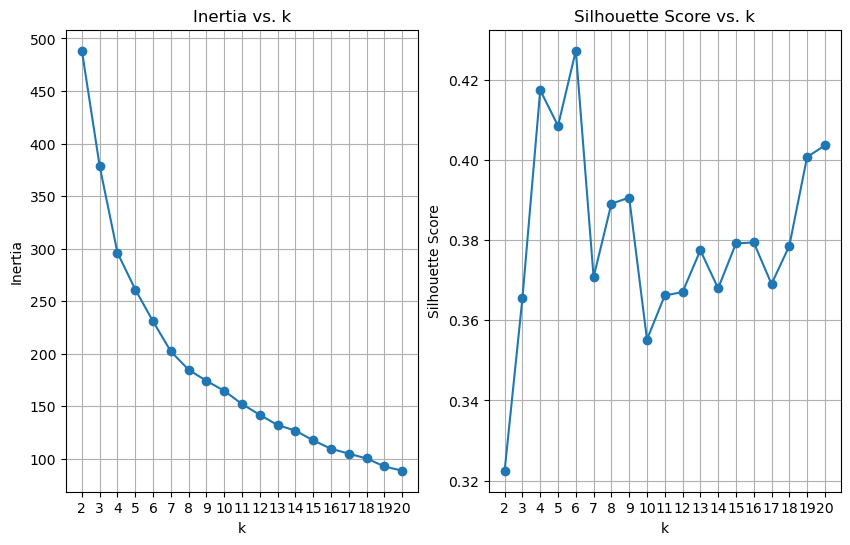

In [7]:
# iterate through ks
ks = range(2,21)
inertias = []
silhouette_scores = []
for k in ks:
    kmeans = KMeans(n_clusters = k, n_init = 15, random_state = 109)
    labels = kmeans.fit_predict(X)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X,labels))
    
# plot
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(ks, inertias, 'o-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Inertia vs. k')
plt.xticks(ks)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(ks, silhouette_scores, 'o-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k')
plt.xticks(ks)
plt.grid()

# Answer

Based on the metrics above, I would pick `k=6` as my optimal number of clusters. 
- The `k=6` silhouette score is the greatest / closest to 1.
- While lower inertia scores are desired—as a low inertia score indicates close bunching of points within a cluster—I wouldn't use it as my main metric. If there are more clusters, then I would want my data points to be far away from the other clusters if possible.
- Even though `k=6` does not have the lowest inertia score, increasing k could lead to overfitting, so a `k=6` is likely the most parsimonious. However, a high inertia score is bound to occur when there are a low number of centroids. 
- Therefore, I would prioritize silhouette score as the primary metric.

<!-- BEGIN QUESTION -->
<div class='exercise'><b>Q0.4 - Cluster Analysis</b></div>

Using the results of fitting K-means with your choice of optimal $k$, create a visualization showing:
   - Your datapoints in the 2D PCA space
   - Points colored by cluster assignment
   - Each `animal_name` annotated on the plot near its corresponding point 

Finally, interpret your results:
   - How well-separated are your clusters?
   - Do the clusters align with biological classifications?
   - Do any points seem to have been assigned to the wrong cluster? You may not be able to tell from your plot alone and so you should investigate this issue using one of the metrics discussed in class.

/Users/main/mamba/envs/cs109b/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


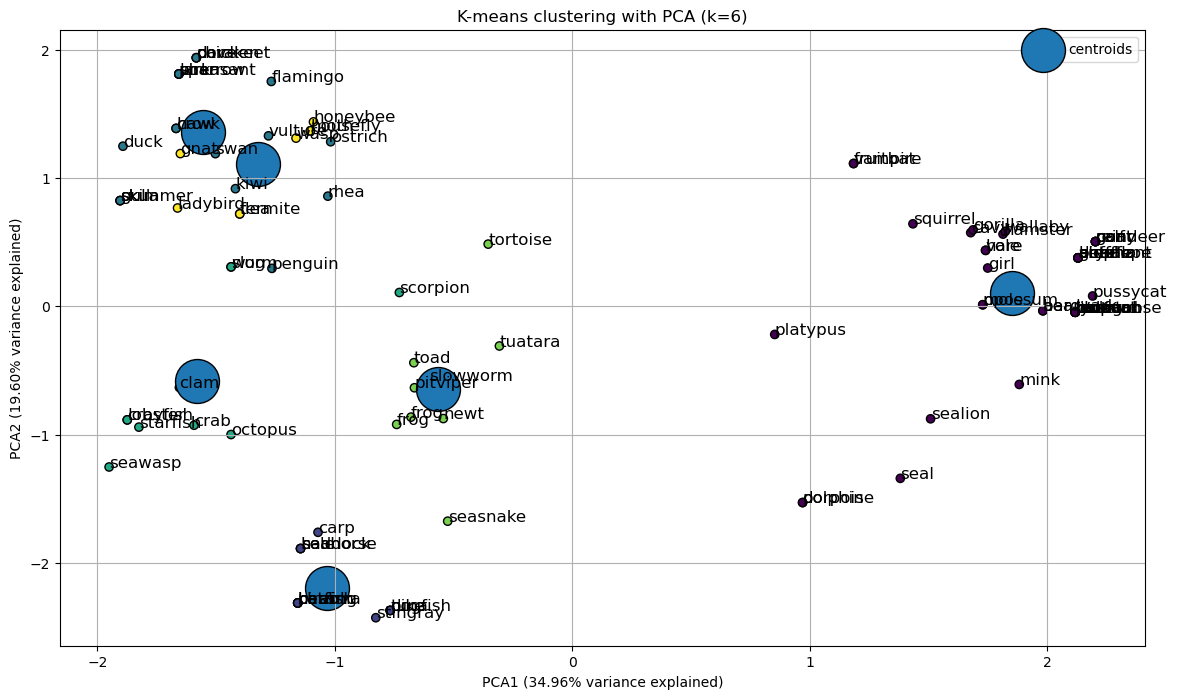

In [8]:
# cluster analysis
kmeans = KMeans(n_clusters=6, n_init=50, random_state=109)
labels = kmeans.fit_predict(X)
centers_pca = pca.transform(kmeans.cluster_centers_)

# plot points
plt.figure(figsize=(14, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, edgecolors = 'k')

# plot centroids and animal names
for i, name in enumerate(animal_names):
    plt.annotate(name, (X_pca[i, 0], X_pca[i, 1]), fontsize=12, alpha=1)

plt.scatter(centers_pca[:, 0], centers_pca[:, 1], marker='o', s=1000, 
            edgecolor='black', label="centroids")

plt.xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)")
plt.ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)")
plt.title("K-means clustering with PCA (k=6)")
plt.legend()
plt.grid()


In [9]:
# further silhouette analysis
silhouette_avg = silhouette_score(X, labels)
print(f"Avg silhouette score: {silhouette_avg:.3f},\n")

silhouette = silhouette_samples(X, labels)
misclassified_possible = np.where(silhouette < 0.15)[0] # some arbitrary threshold lol; just wanted a decent amount of outputs

print("Low silhouette score animals:")
for i in misclassified_possible:
    print(animal_names.iloc[i], f" -> silhouette score: {silhouette[i]:.3f}")


Avg silhouette score: 0.432,

Low silhouette score animals:
dolphin  -> silhouette score: 0.045
porpoise  -> silhouette score: 0.045
scorpion  -> silhouette score: 0.092
seasnake  -> silhouette score: -0.066
slug  -> silhouette score: 0.074
tortoise  -> silhouette score: 0.007
worm  -> silhouette score: 0.074


# Answer

The clusters in the plot are moderately well-separated, but there is some overlap. 
- The clusters centered around fishy and non-fishy sea animals (i.e., clam) are distinct and don't really overlap with others
- The clusters containing mammals and non-flying insects are also relatively distinct.
- However, there is significant overlap between amongst the top-left clusters.

The clusters generally align with biological classifications to a degree:
- Aquatic animals are grouped into either fish or non-fish clusters pretty well.
- Non-flying insects and mammals are also grouped pretty well together.
- We can also see that the winged creatures are well clustered in the top left.

However, there are exceptions. For instance:
- The seasnake seems to be assigned to the insect cluster, when it probably should have been assigned one of the aquatic animal clusters (ideally the non-fishy one).
- Additionally, the tortoise seems also to be assigned to the insect cluster, when it probably should have been assigned one of the aquatic animal clusters (ideally the non-fishy one).

Their sillhouette score also confirms this potential misclassification, as their scores are very low. While the clustering aligns with typical biological classifications in most cases, there are exceptions that highlight potential feature or algorithmic limitations.

In [10]:
# Additional imports for Parts 1-4
import arviz as az
import pymc as pm
from scipy.special import expit

## Hierarchical Bayesian Models

## Dataset Information

### Contraceptive Usage by Bangladeshi Women

For this assignment, you are provided with datasets `train.csv` and `test.csv` which contain details of contraceptive usage among 1,934 Bangladeshi women.

There are four attributes for each woman along with a response variable, `contraceptive_use`, indicating if she uses contraceptives. The four attributes include:

* `district`: code identifying the district in which the woman lives (60 districts in total)
* `urban`: type of region of residence (binary)
* `living.children`: number of living children
* `age-mean`: age of the woman (in years, centered around mean)

The task is to build a classification model that can predict if a given woman uses contraceptives.

The following cell will load and inspect the train and test datasets.

TRAINING DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 37.9 KB

TEST DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
m

,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1


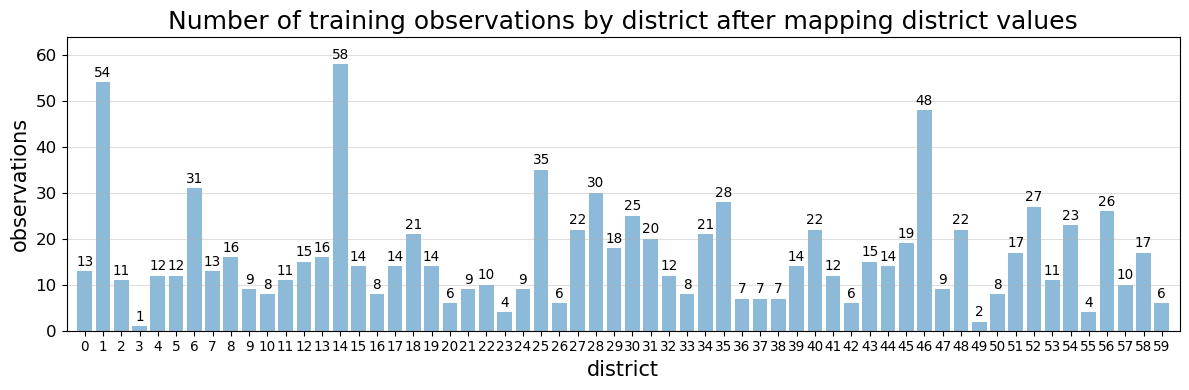

In [11]:
# loading and inspecting the data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

# print dataset summary info for ease of reference
print("TRAINING DATA INFO:\n")
df_train.info()
print("\nTEST DATA INFO:\n")
df_test.info()
print("\nTRAINING DATA SUMMARY STATS:\n")
print(df_train.describe())
print("\nTRAINING DATA FIRST ROWS OF DATA:")
display(df_train.head(3))
print()

# And plot observation counts by district also just for reference
def plot_value_counts(value_counts, var_name, font_perc):
    """Generates barplot from pandas value_counts series"""
    fig, ax = plt.subplots(figsize=(12, 4))

    max_y = max(value_counts.values)
    n_cats = len(value_counts)

    ax.bar(range(n_cats), value_counts.values, alpha=0.5)

    for x, y in enumerate(value_counts):
        ax.text(
            x, y+max_y*.02,
            "{:,}".format(y),
            color="k",
            fontsize=14*font_perc,
            horizontalalignment="center"
        ) 

    ax.set_title(
        "Number of training observations by {} after mapping district values".format(
            var_name
        ),
        fontsize=18
    )
    ax.set_xlabel("{}".format(var_name), fontsize=15)
    ax.set_ylabel("observations", fontsize=15)
    ax.set_xticks(range(n_cats))
    ax.set_xticklabels(value_counts.index)
    ax.tick_params("x", labelsize=14*font_perc)
    ax.tick_params("y", labelsize=12)
    ax.set_ylim(top=max_y+(max_y*.1))

    ax.grid(":", axis="y", alpha=0.4)
    ax.margins(x=.01)
    plt.tight_layout()
    plt.show();

# plot and print summary of resulting district values
dist_counts = df_train["district"].value_counts().sort_index()

plot_value_counts(dist_counts, "district", .7)



## Bayesian Logistic Regression with Varying-Intercept Description


The first model we'd like to fit to the contraceptives data will be a **varying-intercept logistic regression** model, where the model's intercept varies by district.

Prior distributions:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_1 &\sim N(0,10000) 
\\ \\ 
\beta_2 &\sim N(0,10000)
\\ \\ 
\beta_3 &\sim N(0,10000)
\\ \\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} & \sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}
\\ \\
\end{split}
$$

Where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

**PLEASE NOTE:** The $\text{Gamma}$ distribution cited above, uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate.  

<a id="part1"></a>

### <div class='exercise'>Part 1: Varying-Intercept Model (Simulated Response Variable)</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1 - Simulate Response</b></div>

To verify that PyMC can indeed recover the hidden parameter values, we'll simulate values of the response variable, `contraceptive_use`, for observations in the training set using the 4 predictors and *hard-coded model parameters of our choosing*. Then, using this simulated data, we'll check if PyMC can get back the parameter values that we hard-coded. If it does, we'll have some reason to believe that it can recover the hidden parameter values that generated the *real* data.

**Note: Synthetic response values generated using the parameters below will only be used in question 1.1 - 1.4**.

Generate $Y$ using the training data and the following hard-coded values:

$$
\begin{split}
\mu_0 &= 0.5
\\ \\
\sigma^2_0 &= 0.3
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 1
\\ \\ 
\beta_2 &= -0.5
\\ \\
\beta_3 &= -0.3
\\ \\
\end{split}
$$

Save your simulated values in a numpy array called `simulated_Y`.

**Verify that these parameters generate data in which an average of 48% to 50% of subjects use contraceptives.**

In [12]:
print(df_train.columns)
df_train.head()

Index(['district', 'urban', 'living.children', 'age_mean',
       'contraceptive_use'],
      dtype='object')


,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1
3,5,0,3,-4.5599,1
4,34,1,4,8.4400,0


In [13]:
# set seed for consistency across runs...109 (output: 0.503 > 0.50) didn't pass autograder so I changed to 107
np.random.seed(107)

# initial var.
mu_0 = 0.5
sigma_0 = np.sqrt(0.3)
districts = df_train['district'].unique()
beta_0_j = {district: np.random.normal(mu_0, sigma_0) for district in districts}
beta_1 = 1
beta_2 = -0.5
beta_3 = -0.3

logit_p_i_j = beta_0_j = np.array([ beta_0_j[district] + 
                                    beta_1 * urban + 
                                    beta_2 * living_children +
                                    beta_3 * age_mean

for district, urban, living_children, age_mean in zip(df_train['district'], 
                                                      df_train['urban'], 
                                                      df_train["living.children"], 
                                                      df_train["age_mean"])
])

p_i_j = expit(logit_p_i_j)
simulated_Y = np.random.binomial(1,p_i_j)

print(simulated_Y.mean())

0.48500517063081694


In [14]:
grader.check("q#1.1")

q#1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2 - Fit Varying-Intercept Model (Simulated Data)</b></div>

Create and fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested by any warnings from PyMC.

In [15]:
np.random.seed(109)

# districts
districts = df_train['district'].values
unique_districts, districts_idx = np.unique(districts, return_inverse=True)
Y_i_j = simulated_Y

# model
with pm.Model() as varying_intercept_model:
    mu_0 = pm.Normal("mu_0", mu=0, sigma=100)
    one_over_sigma_0_sq = pm.Gamma("one_over_sigma2_0", alpha=0.1, beta=0.1)
    beta_0_j = pm.Normal("beta_0", mu=mu_0, tau=one_over_sigma_0_sq, shape=len(unique_districts))
    beta_1 = pm.Normal("beta_1", mu=0, sigma=100)
    beta_2 = pm.Normal("beta_2", mu=0, sigma=100)
    beta_3 = pm.Normal("beta_3", mu=0, sigma=100)

    # logit
    logit_p = (
        beta_0_j[districts_idx] + 
        beta_1 * df_train['urban'] + 
        beta_2 * df_train['living.children'] + 
        beta_3 * df_train['age_mean']
    )
    
    y_obs = pm.Bernoulli("y_obs", logit_p=logit_p, observed=Y_i_j) # no need for expit function

    # trace (but like actually wtf is this; I still don't understand even after completing this PSET *crying noise*)
    trace = pm.sample(
        draws=3000, 
        tune=1000, 
        chains=4, 
        target_accept=0.97
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, one_over_sigma2_0, beta_0, beta_1, beta_2, beta_3]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 15 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.3 - Convergence Diagnostics</b></div>

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged? Explain your reasoning.


**Hint:** Use the Arviz `plot_trace()` function

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_0               0.444  0.355  -0.219    1.085      0.014    0.010   
one_over_sigma2_0  3.157  2.575   0.602    7.553      0.095    0.067   
beta_1             1.284  0.271   0.771    1.779      0.004    0.003   
beta_2            -0.532  0.111  -0.739   -0.325      0.004    0.003   
beta_3            -0.322  0.027  -0.373   -0.269      0.001    0.000   

                   ess_bulk  ess_tail  r_hat  
mu_0                  681.0    1558.0    1.0  
one_over_sigma2_0     901.0    1233.0    1.0  
beta_1               4880.0    7364.0    1.0  
beta_2                786.0    1881.0    1.0  
beta_3               1877.0    4072.0    1.0  


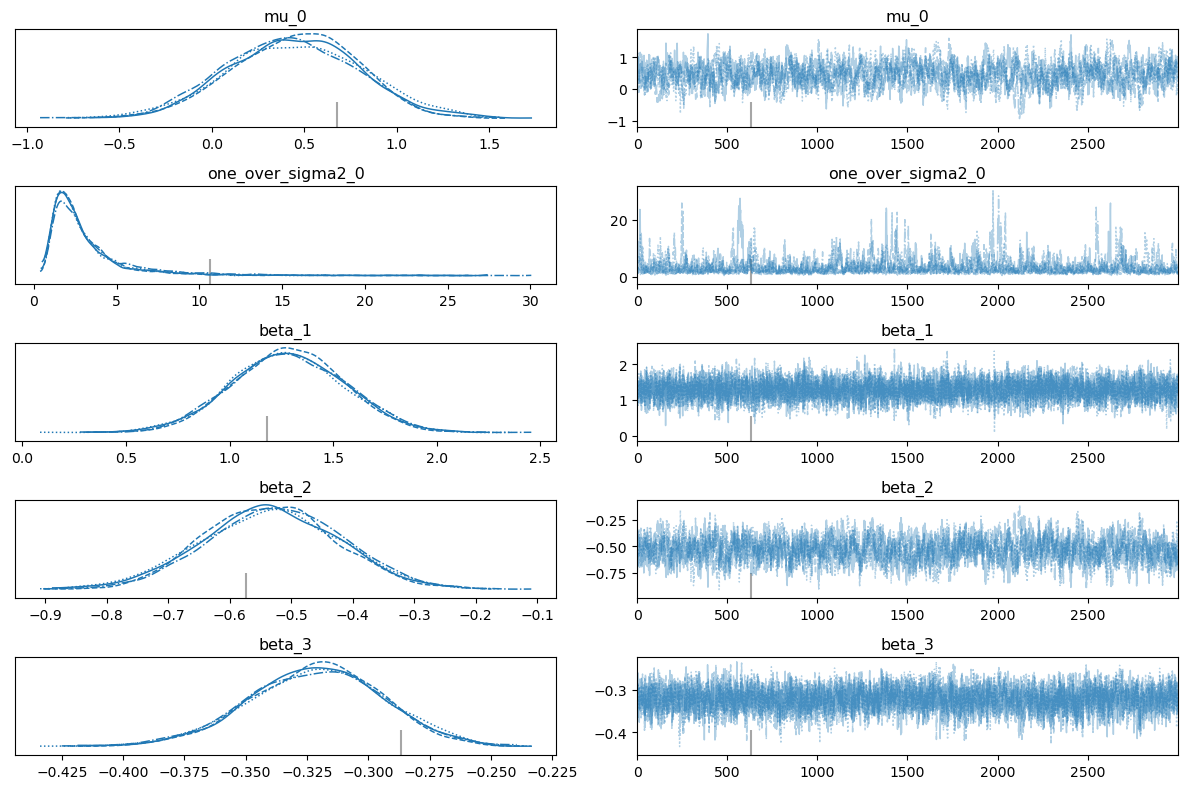

In [16]:
# arviz time
params_to_check = ["mu_0", "one_over_sigma2_0", "beta_1", "beta_2", "beta_3"]

az.plot_trace(trace, var_names=params_to_check, figsize=(12, 8))
plt.tight_layout()
summary = az.summary(trace, var_names=params_to_check)

print(summary)


# Answer

It seems to have converged pretty successfully especially because the `r_hats` are all 1.00 or 1.01, which means they have reached their equillibrium. If we saw `r_hat` > 1.3, then we would be concerned. The trace plots all look pretty okay—that they are pretty centered without any big trends. The $\frac{1}{\sigma_{0}^2}$ trace plot does look a little funky, but that is because it is bounded by $\frac{1}{\sigma_{0}^2}$ > 0. Furthermore, the posterior distributions on the left all look smooth and unimodal. Even the $\frac{1}{\sigma_{0}^2}$ trace plot looks fine, as it follows a Gamma distribution (which we assumed).

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.4 - Inspecting Posteriors</b></div>

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions?

**Hint: The `az.plot_posterior()` function might be helpful here.**

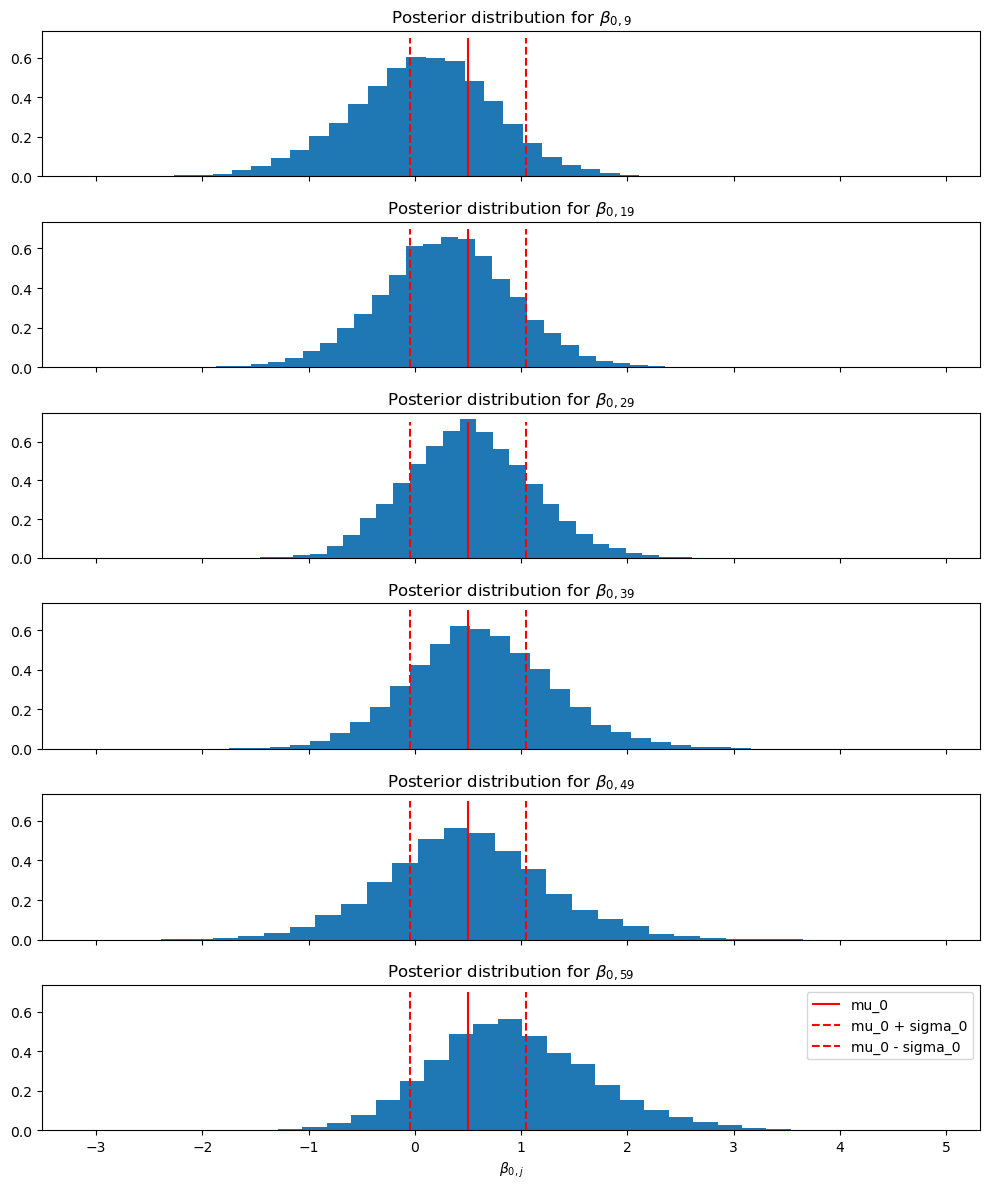

In [17]:
# get the districts
selected_districts = np.arange(9, 60, 10)
beta_0_samples = trace.posterior["beta_0"].values

# plot
fig, axes = plt.subplots(len(selected_districts), 1, figsize=(10, 12), sharex=True)

for i, district_idx in enumerate(selected_districts):
    ax = axes[i]
    ax.hist(beta_0_samples[:, :, district_idx].flatten(), bins=30, density=True)
    ax.set_title(f"Posterior distribution for $\\beta_{{0,{district_idx}}}$")
    ax.vlines(0.5, 0, 0.7, color="red", label="mu_0")
    ax.vlines(0.5+np.sqrt(0.3), 0, 0.7, color="red", label="mu_0 + sigma_0", linestyle="dashed")
    ax.vlines(0.5-np.sqrt(0.3), 0, 0.7, color="red", label="mu_0 - sigma_0", linestyle="dashed")

plt.legend()
plt.xlabel("$\\beta_{0,j}$")
plt.tight_layout()
plt.show()

# Answer

Yes, our actual parameters appear to be contained within the posterior distribution. In the simulation the our $\beta_{0,j}$ were taken from a $\mathcal{N}(0.5, \sqrt{0.3})$ distribution, so the true $\beta_{0,j}$ should be centered around 0.5. The posterior distributions do appear to be centered near 0.5, indicating our posterior distributions most likely captured the true values. Moreover, the posterior distributions have fairly wide tails, so they are likely to capture the variance in the generation of $\beta_{0,j}$. Therefore, we think that the model has effectively caught the district level effects.

<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

### <div class='exercise'>Part 2: Varying-Intercept Model (Real Data)</div> 

[Return to contents](#contents)


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1 - Fit Varying-Intercept Model (Real Data)</b></div>

Now we'll fit our model to the *actual* data. Construct and fit the varying-intercept model to the real training data.

In [18]:
# reusing our code from q1
# model
with pm.Model() as varying_intercept_model_real:
    mu_0 = pm.Normal("mu_0", mu=0, sigma=100)
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)
    sigma_0 =  pm.Deterministic("sigma_0", 1/ pm.math.sqrt(tau_0)) # for 2.4
    beta_0_j = pm.Normal("beta_0", mu=mu_0, tau=tau_0, shape=len(unique_districts))
    beta_1 = pm.Normal("beta_1", mu=0, sigma=100)
    beta_2 = pm.Normal("beta_2", mu=0, sigma=100)
    beta_3 = pm.Normal("beta_3", mu=0, sigma=100)

    # logit
    logit_p = (
        beta_0_j[districts_idx] + 
        beta_1 * df_train['urban'] + 
        beta_2 * df_train['living.children'] + 
        beta_3 * df_train['age_mean']
    )
    # y_obs
    y_obs = pm.Bernoulli("y_obs", logit_p=logit_p, observed=df_train['contraceptive_use'])
    
    trace_real = pm.sample(
        draws=3000, 
        tune=1000, 
        chains=4, 
        target_accept=0.97
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, beta_0, beta_1, beta_2, beta_3]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2 - Convergence Diagnostics</b></div>

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_0   -1.599  0.255  -2.083   -1.123      0.009    0.006     853.0    1686.0   
tau_0   3.895  1.776   1.352    6.973      0.041    0.029    2213.0    2642.0   
beta_1  0.738  0.165   0.435    1.052      0.002    0.001    6384.0    8398.0   
beta_2  0.322  0.083   0.162    0.477      0.003    0.002     922.0    1938.0   
beta_3 -0.035  0.012  -0.056   -0.012      0.000    0.000    1549.0    3665.0   

        r_hat  
mu_0     1.01  
tau_0    1.00  
beta_1   1.00  
beta_2   1.01  
beta_3   1.01  


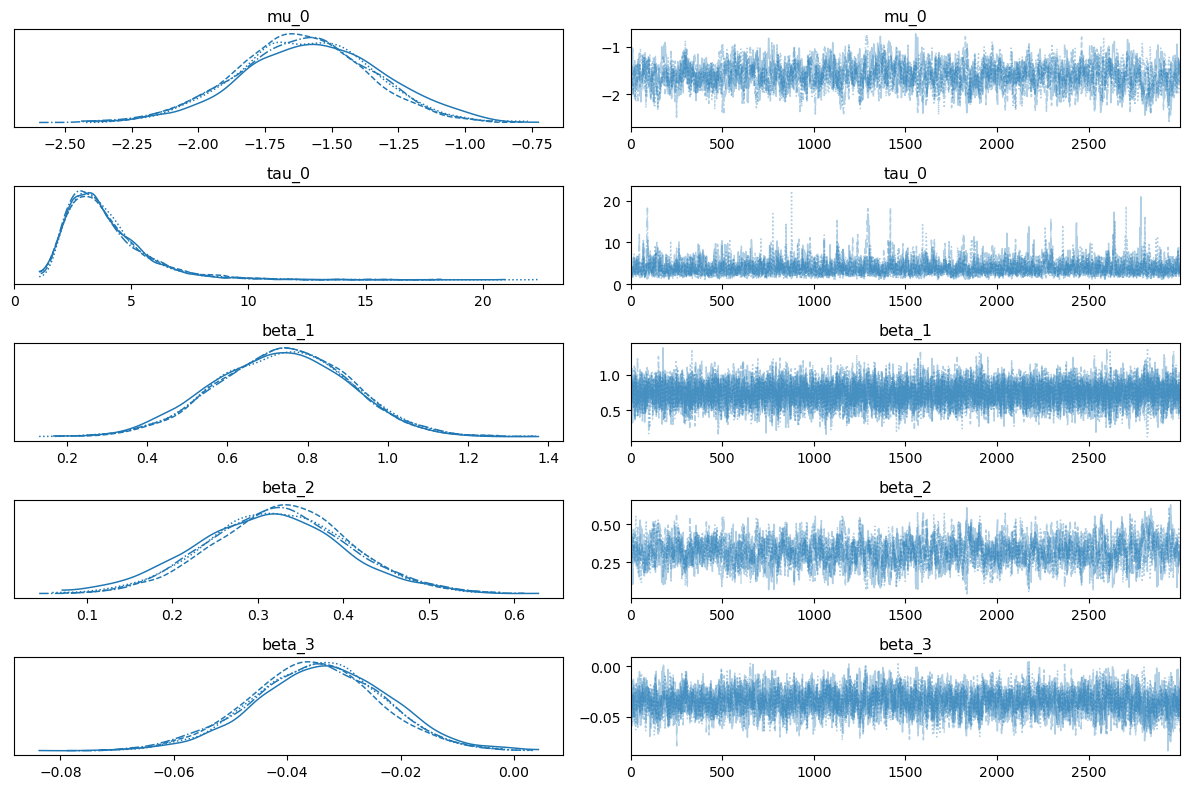

In [19]:
# arviz time
params_to_check = ["mu_0", "tau_0", "beta_1", "beta_2", "beta_3"]

az.plot_trace(trace_real, var_names=params_to_check, figsize=(12, 8))
plt.tight_layout()
summary = az.summary(trace_real, var_names=params_to_check)
print(summary)

# Answer

- All of the rhats were equal to 1.0, which is good because that means all of the coefficients converged.
- The trace plots were similar to what we saw above and indicate convergence. Both the $\tau_0$ and $\beta_j$'s have similar trace plots as the previous part.
- The $\beta_j$ posterior distribution is mainly consistent, with little variation in the distribution, indicating that there is likely a singular value for those $\beta_j$ values.


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.3 - Districts with Highest & Lowest Rates of Contraceptive Usage</b></div>

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest? Explain how you arrived at these conclusions, interpreting any numerical values that played a role in your reasoning.



District with the highest base rate of contraceptive usage:
district_index    56.000000
beta_0_j_mean     -0.689405
Name: 56, dtype: float64

District with the lowest base rate of contraceptive usage:
district_index    11.000000
beta_0_j_mean     -2.196609
Name: 11, dtype: float64


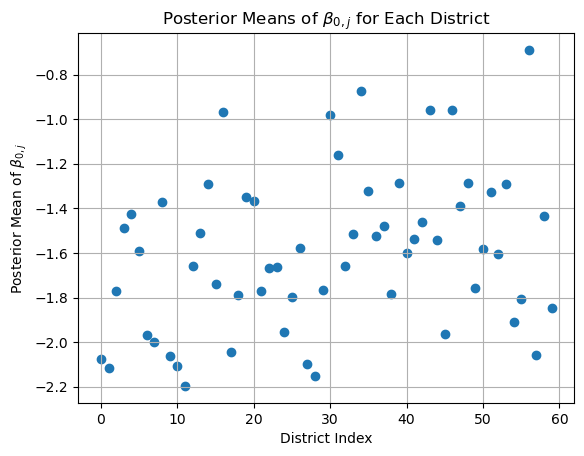

In [20]:
# calculate means of bias for each district
beta_0_j_means = trace_real.posterior['beta_0'].mean(dim=('chain', 'draw')).values

# create a DataFrame to map district indices to their posterior means
districts_posterior_means = pd.DataFrame({
    'district_index': np.arange(len(beta_0_j_means)),
    'beta_0_j_mean': beta_0_j_means
})

# find the district with the highest and lowest base rate
highest_district = districts_posterior_means.loc[districts_posterior_means['beta_0_j_mean'].idxmax()]
lowest_district = districts_posterior_means.loc[districts_posterior_means['beta_0_j_mean'].idxmin()]

print("District with the highest base rate of contraceptive usage:")
print(pd.to_numeric(highest_district)) 

print("\nDistrict with the lowest base rate of contraceptive usage:")
print(pd.to_numeric(lowest_district))

# plot
plt.scatter(districts_posterior_means['district_index'], districts_posterior_means['beta_0_j_mean'])
plt.xlabel('District Index')
plt.ylabel('Posterior Mean of $\\beta_{0,j}$')
plt.grid()
plt.title('Posterior Means of $\\beta_{0,j}$ for Each District')
plt.show()

# Answer

- District 56 has the highest base rate of contraceptive usage because of all the measured districts, it has the highest mean `-0.679`
- District 11 has the lowest base rate of contraceptive usage because of all the measured districts, it has the lowest mean `-2.19`.

As we are ignoring all the other factors, I wanted to look at the $\beta_{0,j}$ for all the districts. As the outcome variable was contraceptive use, if the $\beta_{0,j}$ was the greatest, that means district $j$ has the highest contraceptive use. A similar logic is then applied to find the district with the lowest base contraceptive use rate.


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.4 - Varying Intercept? Conclusions from Posterior Samples</b></div>

What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts? Explain why or why not.


**Hint:** Both ArviZ's `plot_posterior` and [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) functions will prove useful here.

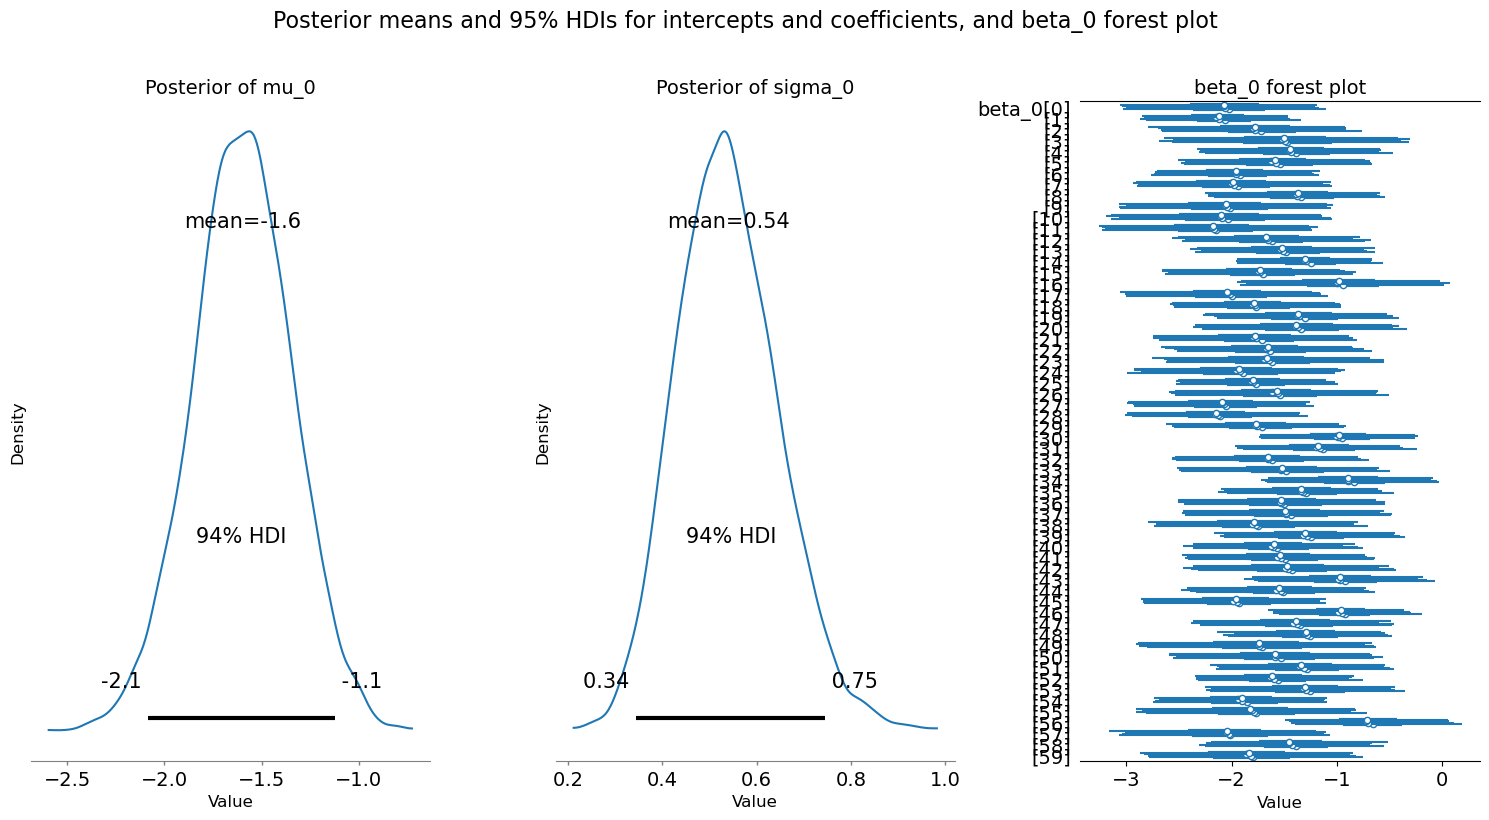

In [21]:
# arviz time
params_to_plot = ["mu_0", "sigma_0"]

# plot posterior distributions for mu_0 and sigma_0
fig, axs = plt.subplots(1, 3, figsize=(15, 8), sharey=False)
fig.suptitle("Posterior means and 95% HDIs for intercepts and coefficients, and beta_0 forest plot", fontsize=16, y=1.02)

for i, param in enumerate(params_to_plot):
    az.plot_posterior(trace_real, var_names=[param], ax=axs[i])
    axs[i].set_title(f"Posterior of {param}", fontsize=14)
    axs[i].set_xlabel("Value", fontsize=12)
    axs[i].set_ylabel("Density", fontsize=12)

# plot beta_0 forest plot
az.plot_forest(trace_real, var_names=["beta_0"], ax=axs[-1])
axs[-1].set_title("beta_0 forest plot", fontsize=14)
axs[-1].set_xlabel("Value", fontsize=12)

plt.tight_layout()
plt.show()

# Answer

Posterior mean of $\mu_0$ = -1.6; Posterior mean of $\sigma_0$ = 0.54

These values, in combination with a $\beta_{0,j}$ forest plot, provide evidence in support of a varying-intercept model compared to a model with a single intercept for all districts. $\sigma_0$'s posterior plot suggests that there is meaningful heterogeneity in the baseline levels across districts, which a single intercept model would fail to capture. We can also see that the forest plot is not perfectly linear, indicating that district-specific differences are significant, requiring different $\beta_{0,j}$. Therefore, the varying-intercept model is more appropriate as it accounts for this variability, providing a more accurate representation of the data. 

<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 3: Varying-Coefficient Model</div> 

[Return to contents](#contents)


The next model we will fit to the contraceptives data is a **varying-coefficients logistic regression** model. Here, in addition to a varying intercept, the coefficients on `living.children`, `age_mean`, and `urban` also vary by district.

Prior distribution:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_{1j} &\sim N(0,\sigma_1^2)\; \text{, with} \;\; \frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1) 
\\
\beta_{2j} &\sim N(0,\sigma_2^2)\; \text{, with} \;\; \frac{1}{\sigma^2_2} \sim \text{Gamma}(0.1,0.1)
\\ 
\beta_{3j} &\sim N(0,\sigma_3^2)\; \text{, with} \;\; \frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)
\\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} &\sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}
\\ \\
\end{split}
$$

**PLEASE NOTE:**

* The name "varying coefficient model" is used here to distinguish the Q3 model from the "varying intercept" model in Q2, but observe from the specification about that **BOTH** intercepts *and* coefficients vary in this Q3 model.
* Once again, the $\text{Gamma}$ distribution uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate. 

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1 - Fit Varying Coefficient Model</b></div>

Fit the varying-coefficients model described above to the real training data.

In [22]:
np.random.seed(109)

# model (as if it wasn't obvious enough)
with pm.Model() as varying_coeff_model:
    mu_0 = pm.Normal("mu_0", mu=0, sigma=100)
    
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)
    beta_0_j = pm.Normal("beta_0", mu=mu_0, tau=tau_0, shape=len(unique_districts))
    
    tau_1 = pm.Gamma("tau_1", alpha=0.1, beta=0.1)
    beta_1_j = pm.Normal("beta_1", mu=0, tau=tau_1, shape=len(unique_districts))
    
    tau_2 = pm.Gamma("tau_2", alpha=0.1, beta=0.1)
    beta_2_j = pm.Normal("beta_2", mu=0, tau=tau_2, shape=len(unique_districts))
    
    tau_3 = pm.Gamma("tau_3", alpha=0.1, beta=0.1)
    beta_3_j = pm.Normal("beta_3", mu=0, tau=tau_3, shape=len(unique_districts))

    logit_p_i_j = (
        beta_0_j[districts_idx] + 
        beta_1_j[districts_idx] * df_train['urban'] + 
        beta_2_j[districts_idx] * df_train['living.children'] + 
        beta_3_j[districts_idx] * df_train['age_mean']
    )
    
    y_obs = pm.Bernoulli("y_obs", logit_p=logit_p_i_j, observed=df_train['contraceptive_use'])

    trace_varying_coeff = pm.sample(
        draws=3000, 
        tune=1000, 
        chains=4, 
        target_accept=0.97
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, beta_0, tau_1, beta_1, tau_2, beta_2, tau_3, beta_3]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 31 seconds.


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.2 - Convergence Diagnostics</b></div>

Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the varying-intercept models earlier. What do you observe?

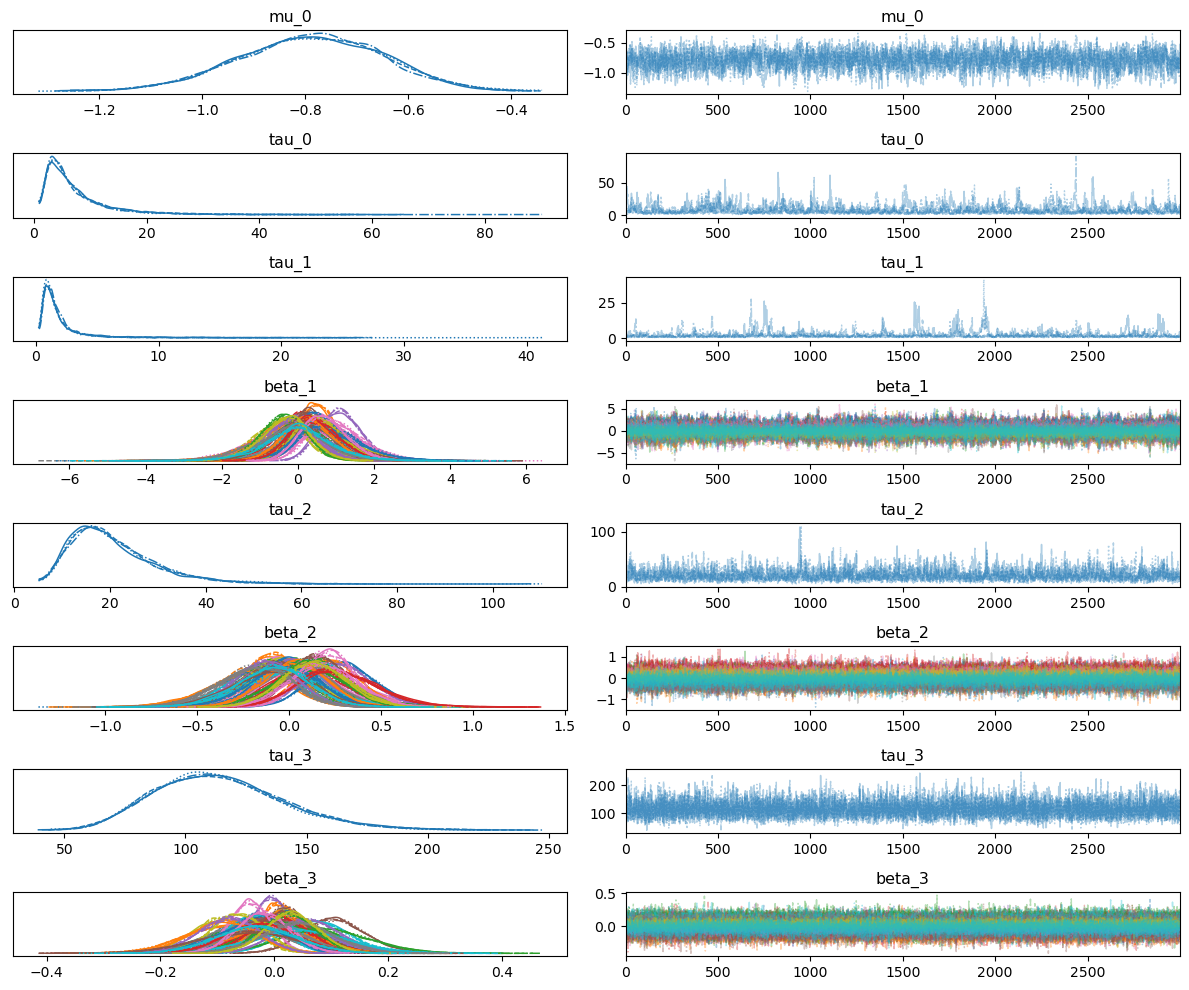

             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_0       -0.790  0.142  -1.061   -0.529      0.003    0.002    1960.0   
tau_0       7.299  6.061   0.980   17.737      0.234    0.166     617.0   
tau_1       1.890  2.096   0.248    4.718      0.091    0.064     654.0   
beta_1[0]   0.621  0.775  -0.742    2.131      0.012    0.010    4288.0   
beta_1[1]   0.540  0.475  -0.344    1.428      0.007    0.005    5379.0   
...           ...    ...     ...      ...        ...      ...       ...   
beta_3[55] -0.048  0.091  -0.218    0.126      0.001    0.001   14514.0   
beta_3[56] -0.019  0.046  -0.106    0.070      0.000    0.000   10095.0   
beta_3[57]  0.042  0.064  -0.079    0.163      0.001    0.000   12659.0   
beta_3[58]  0.031  0.047  -0.057    0.118      0.000    0.000   15406.0   
beta_3[59] -0.032  0.071  -0.167    0.100      0.001    0.001   13494.0   

            ess_tail  r_hat  
mu_0          4059.0   1.00  
tau_0         1362.0   1.01  
tau_1    

In [23]:
# arviz time
params_to_check = ["mu_0", "tau_0", 
                   "tau_1", "beta_1",
                   "tau_2", "beta_2",
                   "tau_3", "beta_3"]

# Generate trace plots
az.plot_trace(trace_varying_coeff, var_names=params_to_check, figsize=(12, 10))
summary = az.summary(trace_varying_coeff, var_names=params_to_check)

plt.tight_layout()
plt.show()
print(summary)

# Answer

All of the parameters above have posterior distributions and trace plots similar to what we encountered in question 2, for both the $\tau$'s and $\beta$'s. Aside from the ocassional spikes in the $\tau$ trace plots, we observe that these coefficients are highly likely to converge, especially because the `r_hat` values are all equal to either 1 or 1.01. Interesting to note is that the $\beta$'s have slightly different posterior distributions.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.3 - Distribution of Posterior Means & HDIs</b></div>

Plot the distributions of posterior means and the 95% highest posterior density intervals (HDIs) for the intercepts and coefficients for each district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.

Text(0.5, 0.98, 'Posterior means and 95% HDIs for intercepts and coeffs')

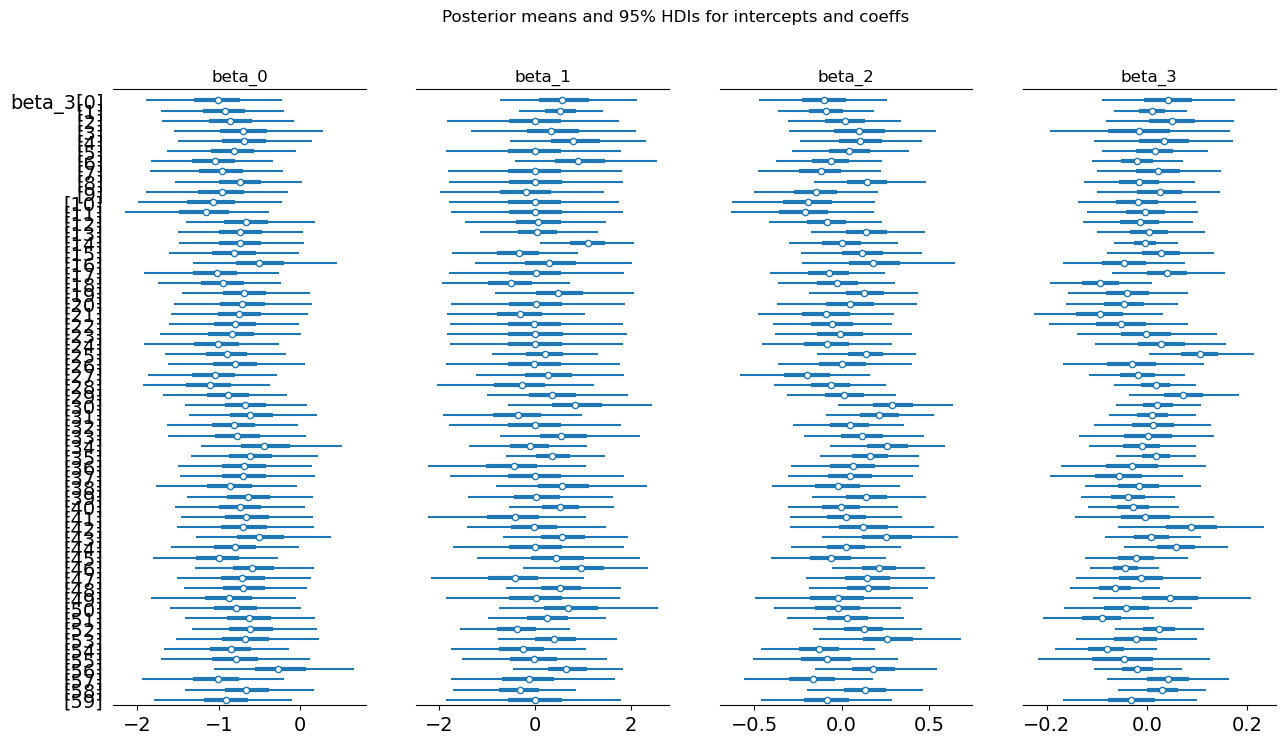

In [24]:
# arviz time
params_to_plot = ["beta_0", "beta_1", "beta_2", "beta_3"]

fig, axs = plt.subplots(1, 4, figsize=(15, 8), sharey=True)

for i, param in enumerate(params_to_plot):
    az.plot_forest(trace_varying_coeff, var_names=[param], 
                   combined=True, ax=axs[i])
    axs[i].set_title(param)

plt.suptitle("Posterior means and 95% HDIs for intercepts and coeffs")

# Answer

There appears to be significant variability in both the intercepts and coefficients across the districts. This suggests that contraceptive use varies by region. Specifically, `beta_2` and `beta_3` exhibit particularly non-linear patterns. Additionally, we can observe that `beta_0` is predominantly negative, as its HDI lies mostly within the < 0 region. In contrast, the other coefficients do not show a clear trend, as their ranges span both negative and positive values equally.

In conclusion, these graphs indicate that there are indeed district-level effects that the varying-coefficient model can capture, particularly for `beta_2` and `beta_3`, which were not adequately captured by the varying-intercept model. As a reminder, `beta_2` and `beta_3` represent the coefficients for the `living.children` and `age-mean` variables, respectively.

<a id="part4"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 4: Predictions & Model Selection</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.1 - Model Evaluation & Comparison</b></div>

Now that we’ve fit varying-intercept and varying-coefficient models we will evaluate their predictive performance and compare them to a naive baseline.
 
First, sample from the posterior predictive distribution using `pm.sample_posterior_predictive()`, generating predictions for both models on the train and test sets.

Next, compute the accuracy and percentage of predictions classified as `1` for each model on both train and test.

Finally, compute the train and test accuracy of a naive model that predicts the most common class in the training set for all inputs.

In [25]:
# manually calculate the posterior predictive (like chris said in lab 3); using pm.sample_posterior_predictive() is hard
def predict(X, trace=trace_real, varying_coef=False, threshold=0.5):
    # extract values from X
    district = X["district"].values
    urban = X["urban"].values
    living_children = X["living.children"].values
    age_mean = X["age_mean"].values
    
    # get number of unique districts
    n_districts = len(unique_districts)
    
    # define logits
    if not varying_coef:
        L = ( # take care in aligning the data | note to graders: this was a MAJOR headache
            trace.posterior["beta_0"].values.reshape(-1, n_districts)[:, district] +
            trace.posterior["beta_1"].values.reshape(-1, 1) * urban.T +
            trace.posterior["beta_2"].values.reshape(-1, 1) * living_children.T +
            trace.posterior["beta_3"].values.reshape(-1, 1) * age_mean.T
        ).T
    else:
        L = (
            trace.posterior["beta_0"].values.reshape(-1, n_districts)[:, district] +
            trace.posterior["beta_1"].values.reshape(-1, n_districts)[:, district] * urban +
            trace.posterior["beta_2"].values.reshape(-1, n_districts)[:, district] * living_children +
            trace.posterior["beta_3"].values.reshape(-1, n_districts)[:, district] * age_mean
        ).T
    
    # Convert logits to probabilities and compute predictions
    P_trace = expit(L)
    P_mean = P_trace.mean(axis=1)
    y_pred = (P_mean > threshold).astype(int)
    
    # Return results
    return {"P_trace": P_trace, "P_mean": P_mean, "y_pred": y_pred}


In [26]:
# 1. generate predictions
# varying intercept model
trace_real_train_predict = predict(df_train, trace_real)
trace_real_test_predict = predict(df_test, trace_real)

# varying coeff model
trace_varying_coeff_train_predict = predict(df_train, trace_varying_coeff, True)
trace_varying_coeff_test_predict = predict(df_test, trace_varying_coeff, True)

In [27]:
# 2. calculate accuracy and percentage of predictions that are 1
# accuracy
trace_real_train_acc = (df_train["contraceptive_use"]==trace_real_train_predict["y_pred"]).astype(int).mean()
trace_real_test_acc = (df_test["contraceptive_use"]==trace_real_test_predict["y_pred"]).astype(int).mean()
trace_varying_coeff_train_acc = (df_train["contraceptive_use"]==trace_varying_coeff_train_predict["y_pred"]).astype(int).mean()
trace_varying_coeff_test_acc = (df_test["contraceptive_use"]==trace_varying_coeff_test_predict["y_pred"]).astype(int).mean()

# percentage of predictions that are 1
trace_real_train_perc = trace_real_train_predict["y_pred"].mean()
trace_real_test_perc = trace_real_test_predict["y_pred"].mean()
trace_varying_coeff_train_perc = trace_varying_coeff_train_predict["y_pred"].mean()
trace_varying_coeff_test_perc = trace_varying_coeff_test_predict["y_pred"].mean()

# make a dataframe for prettier presenting
models = {
    "Model": ["Varying Intercept", "Varying Intercept", "Varying Coefficient", "Varying Coefficient"],
    "Dataset": ["Train", "Test", "Train", "Test"],
    "Accuracy": [
        trace_real_train_acc,
        trace_real_test_acc,
        trace_varying_coeff_train_acc,
        trace_varying_coeff_test_acc,
    ],
    "Percentage_1": [
        trace_real_train_perc,
        trace_real_test_perc,
        trace_varying_coeff_train_perc,
        trace_varying_coeff_test_perc,
    ],
}

# Create a single DataFrame
combined_df = pd.DataFrame(models)
combined_df

,Model,Dataset,Accuracy,Percentage_1
0,Varying Intercept,Train,0.675284,0.224405
1,Varying Intercept,Test,0.655636,0.207859
2,Varying Coefficient,Train,0.702172,0.267839
3,Varying Coefficient,Test,0.619442,0.264736


In [28]:
# 3. naive model inclusion
most_common_class = df_train['contraceptive_use'].mode()[0]
# print(most_common_class); -> output: 0

# naive model predictions
y_pred_naive_train = np.full_like(df_train['contraceptive_use'], most_common_class)
y_pred_naive_test = np.full_like(df_test['contraceptive_use'], most_common_class)

# compute accuracy; percentage of 1s = 1 - accuracy (because 0 is the most common class)
accuracy_naive_train = np.mean(df_train['contraceptive_use'] == y_pred_naive_train)
accuracy_naive_test = np.mean(df_test['contraceptive_use'] == y_pred_naive_test)

print(f"Naive Model Train Accuracy: {accuracy_naive_train}")
print(f"Naive Model Test Accuracy: {accuracy_naive_test}")

Naive Model Train Accuracy: 0.610134436401241
Naive Model Test Accuracy: 0.6049638055842813


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.2 - Model Selection</b></div>

What do you conclude from the results of 4.1? Which model appears to be the best (i.e. varying-intercept, varying-coefficient, or naive), and what is your rationale?

# Answer

From the results of 4.1, I conclude that the varying-intercept model seem to be the best because it has the highest accuracy on `df_test`. Both the varying-coefficient and varying-intercept model outperform the naive model, but the varying-intercept model does better than the varying-coefficient model. 

Even though the varying-coefficient model does do better on the train set, the fact that it does worse on the varying-intercept model is likely indicative of the model overfitting. The varying-intercept model also has the lowest percentage of its predictions being `1`s, which means it likely has the lowest rate of false positives. 


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.3 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

--------------------------

### Answer

- I felt as though I understood the core concepts in this homework and mostly understood the machinations behind the functions. However, using the `pm.Model`—or PyMC in general—was slightly uncomfortable; I'm definitely not used to using this library.

- Wrangling `pm.sample_posterior_predictive()`. Ultimately, under the guidance of OH, manually computed the predictions instead.

- Another difficult aspect was the `.T` for 4.1; this took a ridiculous amount of time to figure out (could have been quicker though if I went to OH sooner).

--------------------------

* How many hours did you spend working on this assignment? Store this as an int or float in `time_spent_on_hw` 

### Answer

12

In [29]:
time_spent_on_hw = 12

*Your answer here*



In [30]:
grader.check("q4.3")

q4.3 results: All test cases passed!

In [31]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 1.32 minutes for this notebook to run


**This concludes HW1. Thank you!** 🌈